In [119]:
BATCH_SIZE=10
TRAIN_SET_SIZE = 400
VALIDATION_SET_SIZE = 133

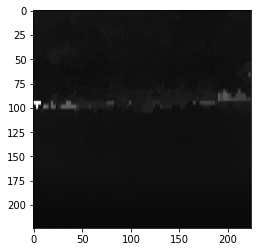

In [120]:
img_path_depth='/Users/mikc/Documents/Datasets/DoF/train/depth/img-stats7-p-344t0.jpg'
img_path_image='/Users/mikc/Documents/Datasets/DoF/train/image/img-stats7-p-344t0.jpg'
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path_depth, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.0
img2 = image.load_img(img_path_image, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 /= 255.0

import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
#plt.imshow(img_tensor2[0])

plt.show()

In [121]:
import os
base_dir='/Users/mikc/Documents/Datasets/DoF/'
train_dir=os.path.join(base_dir, 'train')
train_images_dir = os.path.join(train_dir, 'image')
train_depth_dir = os.path.join(train_dir, 'depth')
validation_dir=os.path.join(base_dir, 'test')
validation_images_dir = os.path.join(validation_dir, 'image')
validation_depth_dir = os.path.join(validation_dir, 'depth')

In [122]:
from keras.applications import VGG16
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense
from keras.models import Model
from keras.optimizers import RMSprop, Adam

#from keras.applications.vgg16 import VGG16

conv_base = VGG16(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False
)



conv_base.summary()

def VGG16_encoder_decoder(input_img, base_model):

    for layer in base_model.layers:
        layer.trainable=False
    
#-------------------encoder---------------------------- 
#--------(pretrained & trainable if selected)----------

#    block1
    x=base_model.get_layer('block1_conv1')(input_img)
    x=base_model.get_layer('block1_conv2')(x)
    x=base_model.get_layer('block1_pool')(x)

#    block2
    x=base_model.get_layer('block2_conv1')(x)
    x=base_model.get_layer('block2_conv2')(x)
    x=base_model.get_layer('block2_pool')(x)

#    block3
    x=base_model.get_layer('block3_conv1')(x)
    x=base_model.get_layer('block3_conv2')(x)
    x=base_model.get_layer('block3_conv3')(x)    
    x=base_model.get_layer('block3_pool')(x)

#    block4
    x=base_model.get_layer('block4_conv1')(x)
    x=base_model.get_layer('block4_conv2')(x)
    x=base_model.get_layer('block4_conv3')(x)    
    x=base_model.get_layer('block4_pool')(x)

#    block5
    x=base_model.get_layer('block5_conv1')(x)
    x=base_model.get_layer('block5_conv2')(x)
    x=base_model.get_layer('block5_conv3')(x)
     
    
#--------latent space (trainable) ------------
    x=base_model.get_layer('block5_pool')(x)     
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='latent')(x)
    x = UpSampling2D((2,2))(x)  
    
#--------------decoder (trainable)----------- 
        
  # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock5_conv3')(x)
    x = UpSampling2D((2,2))(x)

  # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='dblock4_conv3')(x)
    x = UpSampling2D((2,2))(x)

  # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='dblock3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='dblock3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='dblock3_conv3')(x)
    x = UpSampling2D((2,2))(x)     
     
  # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock2_conv3')(x)
    x = UpSampling2D((2,2))(x)        
 
  # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(3, (3, 3), activation='relu', padding='same', name='dblock1_conv3')(x)
#    x = UpSampling2D((2,2))(x) 
    
    return x


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [123]:
input_image = Input(shape = (224, 224, 3))

autoencoder=Model(input_image, VGG16_encoder_decoder(input_image, conv_base))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam(), metrics=['accuracy'])
optimizer='adam', #optimizers.RMSprop(lr=2e-5),
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [124]:
import random
import cv2
import os
import glob
import itertools
from keras.preprocessing import image
#from keras.preprocessing.image.utils import load_img, img_to_array
import numpy as np

def read_image2(img_path, width=224, height=224):
    img = image.load_img(img_path, target_size=(width, height))
    img_tensor = image.img_to_array(img)
    #img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0
    return img_tensor

def read_image(image, width=224, height=224):
    img = cv2.imread(image, 1)
    img = cv2.resize(img, (width, height))
    img = img.astype(np.float32)
    img = img/255.0
    
    
def get_pairs_from_paths(image_dir, depth_dir):
    image_glob=os.path.join(image_dir, "*jpg")

    image_pairs=[]

    for f in glob.glob(image_glob):
        base = os.path.basename(f)
        depth = os.path.join(depth_dir, base)
        if os.path.exists(depth):
            image_pairs.append((f, depth))


    #random.shuffle(image_pairs)
    return image_pairs
    
    
def image_depth_generator(images_path, segs_path, batch_size=1,
                                 output_height=224, output_width=224,
                                 do_augment=False):

    img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
    random.shuffle(img_seg_pairs)
    zipped = itertools.cycle(img_seg_pairs)

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = next(zipped)
            #print(im)
            #print(seg)
            X.append(read_image2(im, width=output_width, height=output_height))
            Y.append(read_image2(seg, width=output_width, height=output_height))
        #print(np.array(X))
        yield (np.array(X), np.array(Y))

# combine generators into one which yields image and masks
train_generator = image_depth_generator(train_images_dir, train_depth_dir, batch_size=BATCH_SIZE)
validation_generator = image_depth_generator(validation_images_dir, validation_depth_dir, batch_size=BATCH_SIZE)


In [48]:
X=[]
X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/test/image/img-stats7-p-219t0.jpg'))
#X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/test/image/img-op29-p-295t000.jpg'))
X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/train/image/img-10.21op3-p-047t000.jpg'))
X.append(read_image2('/Users/mikc/Documents/Datasets/DoF/train/image/img-10.21op3-p-047t000.jpg'))
for i in range(400):
    print(i)
    next(validation_generator)
    
Z=np.array(X)
Z.shape

0
/Users/mikc/Documents/Datasets/DoF/test/image/img-math4-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math4-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats6-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats6-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats1-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats1-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats10-p-108t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats10-p-108t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math14-p-188t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math14-p-188t0.jpg
1
/Users/mikc/Documents/Datasets/DoF/test/image/img-math12-p-343t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math12-p-343t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op23-p-015t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op23-p-015t000.jpg
/Users/mikc/Documents/Datasets/DoF

/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.10.14-p-049t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.10.14-p-049t000.jpg
12
/Users/mikc/Documents/Datasets/DoF/test/image/img-op29-p-325t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op29-p-325t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-real8-p-312t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-real8-p-312t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-gatesback1-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-gatesback1-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats8-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats8-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op20-p-108t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op20-p-108t000.jpg
13
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats8-p-282t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats8-p-282t0.jpg


/Users/mikc/Documents/Datasets/DoF/test/image/img-math15-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math15-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.35.48-p-285t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.35.48-p-285t000.jpg
24
/Users/mikc/Documents/Datasets/DoF/test/image/img-math8-p-138t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math8-p-138t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math12-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math12-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op9-p-251t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op9-p-251t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op1-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op1-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op57-p-078t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op57-p-078t000.jpg
25
/U

/Users/mikc/Documents/Datasets/DoF/test/image/img-op33-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op33-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op27-p-251t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op27-p-251t000.jpg
36
/Users/mikc/Documents/Datasets/DoF/test/image/img-op2-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op2-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op14-p-077t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op14-p-077t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op39-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op39-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats1-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats1-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math7-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math7-p-139t0.jpg
37
/Users/mikc/Documents/Datasets/D

48
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats2-p-14t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats2-p-14t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op3-p-283t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op3-p-283t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-combined1-p-220t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-combined1-p-220t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op2-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op2-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math5-p-250t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math5-p-250t0.jpg
49
/Users/mikc/Documents/Datasets/DoF/test/image/img-math4-p-344t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math4-p-344t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-manmade5-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-manmade5-p-313t0.jpg
/Users/m

/Users/mikc/Documents/Datasets/DoF/test/image/img-op36-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op36-p-220t000.jpg
60
/Users/mikc/Documents/Datasets/DoF/test/image/img-manmade5-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-manmade5-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op20-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op20-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op6-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op6-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math1-p-282t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math1-p-282t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op58-p-047t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op58-p-047t000.jpg
61
/Users/mikc/Documents/Datasets/DoF/test/image/img-math9-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math9-p-169t0.jpg
/Users/mikc/Document

/Users/mikc/Documents/Datasets/DoF/test/image/img-gatesback2-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-gatesback2-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math15-p-107t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math15-p-107t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math16-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math16-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op7-p-343t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op7-p-343t000.jpg
73
/Users/mikc/Documents/Datasets/DoF/test/image/img-op57-p-314t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op57-p-314t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op27-p-108t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op27-p-108t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math12-p-108t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math12-p-108t0.jpg
/Users/mikc/Documents/Datas

84
/Users/mikc/Documents/Datasets/DoF/test/image/img-op58-p-344t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op58-p-344t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math13-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math13-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats6-p-107t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats6-p-107t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math8-p-343t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math8-p-343t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats11-p-251t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats11-p-251t0.jpg
85
/Users/mikc/Documents/Datasets/DoF/test/image/img-math8-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math8-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op52-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op52-p-046t000.jpg
/Users/mikc/Documents/Datasets/D

96
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats3-p-220t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats3-p-220t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-real9-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-real9-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math6-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math6-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op6-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op6-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-real8-p-343t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-real8-p-343t0.jpg
97
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats6-p-77t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats6-p-77t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op13-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op13-p-046t000.jpg
/Users/mikc/Documents/Datase

108
/Users/mikc/Documents/Datasets/DoF/test/image/img-gatesback4-p-108t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-gatesback4-p-108t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.28.10-p-161t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.28.10-p-161t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats4-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats4-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op9-p-343t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op9-p-343t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op57-p-016t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op57-p-016t000.jpg
109
/Users/mikc/Documents/Datasets/DoF/test/image/img-op36-p-282t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op36-p-282t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-statroad2-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stat

/Users/mikc/Documents/Datasets/DoF/test/image/img-op52-p-108t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op52-p-108t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats11-p-281t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats11-p-281t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-combined1-p-251t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-combined1-p-251t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op2-p-015t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op2-p-015t000.jpg
121
/Users/mikc/Documents/Datasets/DoF/test/image/img-op31-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op31-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op23-p-108t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op23-p-108t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.10.14-p-316t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.10.14-p-316t

/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.51.18-p-018t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.51.18-p-018t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-10.21op2-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-10.21op2-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-combined1-p-170t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-combined1-p-170t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op27-p-015t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op27-p-015t000.jpg
133
/Users/mikc/Documents/Datasets/DoF/test/image/img-math4-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math4-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats6-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats6-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats1-p-15t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats1-p-15t0.jpg


144
/Users/mikc/Documents/Datasets/DoF/test/image/img-op36-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op36-p-313t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats3-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats3-p-139t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math8-p-46t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math8-p-46t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op1-p-282t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op1-p-282t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.10.14-p-049t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.10.14-p-049t000.jpg
145
/Users/mikc/Documents/Datasets/DoF/test/image/img-op29-p-325t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op29-p-325t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-real8-p-312t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-real8-p-312t0.jpg
/Users/mikc/

156
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats7-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats7-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op31-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op31-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-manmade6-p-77t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-manmade6-p-77t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math15-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math15-p-169t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.35.48-p-285t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.35.48-p-285t000.jpg
157
/Users/mikc/Documents/Datasets/DoF/test/image/img-math8-p-138t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math8-p-138t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math12-p-189t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math12-p-189t0.jpg
/Use

168
/Users/mikc/Documents/Datasets/DoF/test/image/img-math3-p-170t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math3-p-170t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-math8-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math8-p-313t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats9-p-251t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats9-p-251t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op33-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op33-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op27-p-251t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op27-p-251t000.jpg
169
/Users/mikc/Documents/Datasets/DoF/test/image/img-op2-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op2-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op14-p-077t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op14-p-077t000.jpg
/Users/mikc/Documents/Datasets/D

/Users/mikc/Documents/Datasets/DoF/test/image/img-math12-p-108t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math12-p-108t0.jpg
180
/Users/mikc/Documents/Datasets/DoF/test/image/img-op55-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op55-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op10-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op10-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op2-p-282t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op2-p-282t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op23-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op23-p-139t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.10.14-p-080t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.10.14-p-080t000.jpg
181
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats2-p-14t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats2-p-14t0.jpg
/Users/m

/Users/mikc/Documents/Datasets/DoF/test/image/img-op52-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op52-p-046t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats3-p-45t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats3-p-45t0.jpg
192
/Users/mikc/Documents/Datasets/DoF/test/image/img-math2-p-77t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-math2-p-77t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats8-p-343t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats8-p-343t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-060705-17.35.48-p-254t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-060705-17.35.48-p-254t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-stats4-p-251t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats4-p-251t0.jpg
/Users/mikc/Documents/Datasets/DoF/test/image/img-op36-p-220t000.jpg
/Users/mikc/Documents/Datasets/DoF/test/depth/img-op36-p-220t000.jpg
193
/Users/mik

KeyboardInterrupt: 

In [125]:
#next(train_generator)
from keras.callbacks import ModelCheckpoint
#from keras import optimizers
from keras.models import Sequential
model = Sequential()
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

hist=autoencoder.fit_generator(
    train_generator,
    steps_per_epoch=TRAIN_SET_SIZE // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SET_SIZE // BATCH_SIZE,
    verbose=1,
    
    callbacks=callbacks_list,
    epochs=75)

Epoch 1/75
40/40 [==============================] - 777s 19s/step - loss: 67.9300 - accuracy: 0.6980 - val_loss: 0.1918 - val_accuracy: 0.9867

Epoch 00001: saving model to weights-improvement-01-0.99.hdf5
Epoch 2/75
40/40 [==============================] - 773s 19s/step - loss: 0.1351 - accuracy: 0.9993 - val_loss: 0.1519 - val_accuracy: 1.0000

Epoch 00002: saving model to weights-improvement-02-1.00.hdf5
Epoch 3/75
40/40 [==============================] - 815s 20s/step - loss: 0.1351 - accuracy: 1.0000 - val_loss: 0.1093 - val_accuracy: 1.0000

Epoch 00003: saving model to weights-improvement-03-1.00.hdf5
Epoch 4/75
40/40 [==============================] - 676s 17s/step - loss: 0.1351 - accuracy: 1.0000 - val_loss: 0.1315 - val_accuracy: 1.0000

Epoch 00004: saving model to weights-improvement-04-1.00.hdf5
Epoch 5/75
40/40 [==============================] - 637s 16s/step - loss: 0.1351 - accuracy: 1.0000 - val_loss: 0.1647 - val_accuracy: 1.0000

Epoch 00005: saving model to weights

KeyboardInterrupt: 

In [104]:
#autoencoder = Sequential()
autoencoder.load_weights("weights-improvement-01-1.00.hdf5")

In [117]:
import matplotlib.pyplot as plt
#acc = hist.history['accuracy']
#val_acc = hist.history['val_accuracy']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(loss)+1)




<Figure size 432x288 with 0 Axes>

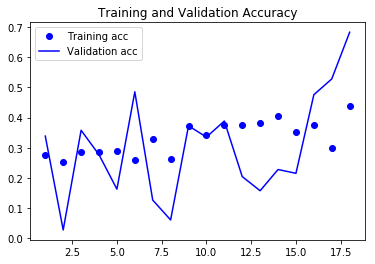

<Figure size 432x288 with 0 Axes>

In [106]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

In [107]:
#test_path = '/Users/mikc/Downloads/katri-vinor-02-uprava.jpg'
#test_path = '/Users/mikc/Downloads/katri-vinor-03.jpg'
#test_path = '/Users/mikc/Documents/Datasets/DoF/train/image/img-stats9-p-77t0.jpg'
#test_path = '/Users/mikc/Documents/Datasets/DoF/train/image/img-stats9-p-219t0.jpg'
test_path = '/Users/mikc/Documents/Datasets/DoF/test/image/img-stats9-p-251t0.jpg'
#g_path = '/Users/mikc/Documents/Datasets/DoF/test/depth/img-stats9-p-251t0.jpg'
#test_path = '/Users/mikc/Downloads/20200226_144155.jpg'
#test_image = np.array([read_image2(g_path)])
test_image = np.array([read_image2(test_path)])
test_image.shape


(1, 224, 224, 3)

In [108]:
Y=autoencoder.predict(test_image)

In [109]:
Y.shape


(1, 224, 224, 3)

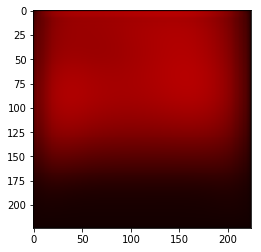

In [110]:
plt.imshow(Y[0])

#plt.imshow(test_image[0])

plt.show()